# [Selected Problems in Machine Learning (NPFL097)](https://ufal.mff.cuni.cz/courses/npfl097)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob

In [2]:
glob("data/*")

['data/dictionary.txt', 'data/test_data.tsv', 'data/training_data.tsv']

In [3]:
train = np.genfromtxt("data/training_data.tsv", delimiter="\t", dtype=np.int32)
test = np.genfromtxt("data/test_data.tsv", delimiter="\t", dtype=np.int32)
dictionary = np.genfromtxt("data/dictionary.txt", dtype=np.string_)

In [4]:
dictionary

array([b'aarp', b'abandon', b'abandoned', ..., b'zogbys', b'zone',
       b'zones'], dtype='|S40')

## Question 1.

**Using the training data, compute the maximum likelihood estimation over the words across
the documents. Plot a histogram showing 20 most probable words.**

The model is just a Multinomial distribution, that is

$$
p(x | \pi, n) = \binom{n!}{x_1!,x_2!,\ldots,x_m!} \prod_{i=1}^m \pi_i^{x_i} = n! \prod_{i=1}^m \frac{\pi_i^{x_i}}{x_i!}
$$

where $\pi_i$ is the probability of $i-th$ word, $x_i$ is the number of occurences of the $i-th$ word, $m$ is the number of words in the dictionary, and $n$ is the total number of occurences.

We compute $\pi_i$ using MLE, that is simply

$$
\pi_i = \frac{x_i}{n}.
$$

In [5]:
def compute_counts(n, document):
    counts = np.zeros(n, np.int32)
    
    for document_id, word_id, count in document:
        counts[word_id - 1] += count
        
    return counts

In [7]:
counts = compute_counts(len(dictionary), train)
n = counts.sum()
m = len(dictionary)
pi_mle = counts.astype(np.float32) / n

Most probable word is simply the one with the highest MLE

In [8]:
dictionary[np.argmax(pi_mle)]

b'bush'

In [9]:
max(counts), max(pi_mle)

(3833, 0.014097198214036146)

In [10]:
max_mle = pi_mle[np.argsort(pi_mle)[-20:]]
most_probable_words = dictionary[np.argsort(pi_mle)[-20:]]

In [11]:
max_mle

array([0.00340937, 0.00342776, 0.00343143, 0.00344615, 0.00352706,
       0.00353441, 0.00384335, 0.00388749, 0.00401989, 0.00432883,
       0.00450537, 0.00468558, 0.00497245, 0.00498716, 0.00534392,
       0.00535863, 0.00570067, 0.00841124, 0.00967642, 0.0140972 ])

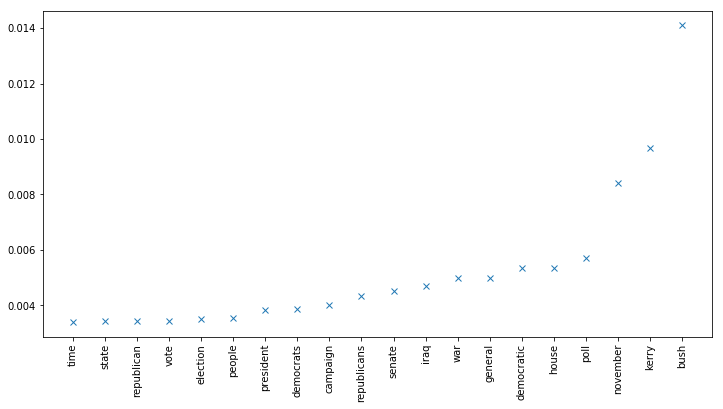

In [12]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
plt.plot(most_probable_words, max_mle, "x")

## Question 2.

**What is the log-probability of the test data if we use the MLE model from question 1)? Note
that the test set contains words which are not contained in the training set. Explain**

The log probability is then

$$
\begin{align}
\log \left( n! \prod_{i=1}^m \frac{\pi_i^{x_i}}{x_i!} \right) &= \log n! + \sum_{i=1}^m x_i \log \pi_i - \sum_{i=1}^m \log x_i! \\
&= \sum_{i=1}^n \log i + \sum_{i=1}^m x_i \log \pi_i - \sum_{i=1}^m \sum_{j=1}^{x_i} \log j
\end{align}
$$

In [32]:
def logfact(k):
    return np.sum(np.log(np.array(range(int(k)), dtype=np.float32) + 1))

def log_prob(dataset, dictionary, pi):
    m = len(dictionary)
    counts = compute_counts(m, dataset)
    n = counts.sum()
    
    t1 = np.sum(np.log(np.array(range(n)) + 1))

    t2_idx = pi > 0

    t2_p = np.zeros(m, dtype=np.int32)
    t2_p[t2_idx] = counts[t2_idx] * np.log(pi[t2_idx])
    
    t2 = t2_p.sum()

    t3_idx = counts > 0

    t3_p = np.zeros(m, dtype=np.float32)
    t3_p[t3_idx] = np.vectorize(logfact)(counts[t3_idx])

    t3 = t3_p.sum()

    return t1 + t2 - t3

In [36]:
log_prob(test, dictionary, pi_mle)

-20265.71938024508

## Question 3.

**Instead of MLE, do the Bayesian inference model on the training data using a symmetric Dirichlet prior with a concentration parameter 0.1. Provide a formula for the predictive distribution.**

I'm not sure what the *predictive distribution* is in this context, since it could be either for the Dirichlet-Categorical or the Dirichlet-Multinomial, so I'm going to provide both :)

In general, posterior predictive is

$$
p(X | D) = \int p(X|\theta) p(\theta|D)\ d\theta
$$

For Dirichlet-Categorical ($Dir(\alpha + D)$ means the posterior for $p(\alpha|D)$, which for Dirichlet-Categorical is just adding the psuedo-counts together, where $D$ are the pseudo-counts, $\boldsymbol\pi$ is the Categorical probabilities, $\boldsymbol\alpha$ are the concentrations).

$$
\begin{align}
p(X=j | D) &= \int p(X=j|\boldsymbol\pi) p(\boldsymbol\pi|D)\ d\pi \\
&= \int Cat(X=j|\boldsymbol\pi) p(\boldsymbol\pi|D)\ d\pi \\
&= \int \boldsymbol\pi_j p(\boldsymbol\pi|D) \ d\pi 
\end{align}
$$

splitting the integral into $\pi_{\neg j} = (\pi_1, \ldots, \pi_{j-1},\pi_{j+1},\ldots, \pi_m)$ and $\pi_j$ and writing it as a double integral

$$
\begin{align}
&= \int \int \boldsymbol\pi_j p(\boldsymbol\pi|D) \ d\pi_{\neg j}\ d\pi_j \\
&= \int \pi_j \int p(\boldsymbol\pi|D) \ d\pi_{\neg j}\ d\pi_j \\
&= \int \pi_j p(\pi_j) d\pi_j
\end{align}
$$

where the last equation is simply because of marginalization. This is simply 

$$
E[\pi_j | D] = \frac{\alpha_j + x_j}{\sum_{i=1}^m (\alpha_i + x_i)}
$$

For the Dirichlet-Multinomial we get the following posterior predictive

$$
\begin{align}
p(X|D) &= \int p(X | \boldsymbol\pi) p(\boldsymbol\pi | D)\ d\boldsymbol\pi \\
&= \int Mult(X | \boldsymbol\pi) Dir(\boldsymbol\alpha') \ d\boldsymbol\pi \\
&= \int \left(\binom{n!}{x_1! \ldots x_m!} \prod_{i=1}^m \pi_i^{x_i} \right)
\left(\frac{1}{B(\boldsymbol\alpha + \boldsymbol x)} \prod_{i=1}^m \pi_i^{\alpha_i' - 1} \right)
\ d\boldsymbol\pi \\
&= \binom{n!}{x_1! \ldots x_m!} \frac{1}{B(\boldsymbol\alpha')}
\int \prod_{i=1}^m \pi_i^{x_i} \prod_{i=1}^m \pi_i^{\alpha_i' - 1} \ d\boldsymbol\pi \\
&= \binom{n!}{x_1! \ldots x_m!} \frac{1}{B(\boldsymbol\alpha')}
\int \prod_{i=1}^m \pi_i^{x_i + \alpha_i' - 1} \ d\boldsymbol\pi \\
&= \binom{n!}{x_1! \ldots x_m!} \frac{1}{B(\boldsymbol\alpha')} B(\boldsymbol\alpha' + \boldsymbol x) \\
\end{align}
$$

I'm not sure how to simplify this further, except for plugging in the general Multinomial constant term

$$
\binom{n!}{x_1! \ldots x_m!} = \frac{\Gamma(\sum_{i=1}^m x_i + 1)}{\prod_{i=1}^m \Gamma(x_i + 1)}
$$

but even then there does not seem to be a simple way.

**In any case, I'll simply assume the Dirichlet-Categorical case in the rest of the code.**

In [56]:
def dirichlet_categorical_posterior(dictionary, dataset, alpha):
    counts = compute_counts(len(dictionary), dataset)
    n = counts.sum()
    m = len(dictionary)

    return (counts.astype(np.float32) + alpha) / (n + m*alpha)
    
    return pi_posterior

In [57]:
pi_posterior = dirichlet_categorical_posterior(dictionary, train, 0.1)
pi_posterior

array([1.50409815e-05, 6.27319023e-05, 4.80577728e-05, ...,
       6.27319023e-05, 1.17759875e-04, 2.23780462e-05], dtype=float32)

## Question 4:

**Using the Bayesian model from question 3, compute the log probability and the per-word perplexity of the test data.**

In [58]:
print(f"Train log P = {log_prob(train, dictionary, pi_posterior)}")
print(f"Test log P = {log_prob(test, dictionary, pi_posterior)}")

Train log P = -13438.027776197065
Test log P = -23074.71938024508


$$
\exp\left(-\log p(data) / n\right) = \exp\left(-\log \prod_{i=1}^m \pi_i^{x_i} / n\right) = \exp\left(-\sum_{i=1}^m x_i \log \pi_i / n \right)
$$

In [59]:
def per_word_perplexity(dictionary, dataset, pi):
    x_i = compute_counts(len(dictionary), dataset)
    n = np.sum(x_i)

    return np.exp(- np.sum(x_i * np.log(pi)) / n)

In [60]:
print(f"Per word perplexity = {per_word_perplexity(dictionary, test, pi_posterior)}")

Per word perplexity = 2697.1067710659086


# Question 5:

**Compute the per-word perplexity of the test data using uniform multinomial dictribution
over the dictionary. Compare this value to the previously computed perplexities and explain.**

Assuming uniform Dirichlet prior with concentration $\alpha = 1$.

In [86]:
pi_posterior_uniform = dirichlet_categorical_posterior(dictionary, train, 1)

print(f"Uniform prior perplexity = {per_word_perplexity(dictionary, test, pi_posterior_uniform)}")

Uniform prior perplexity = 2683.984070350858


I'm not sure how to compare the perplexities. Looking at the log probabilities for $\alpha=0.1$ and $\alpha=1$ it is quite obvious that it does what it should, that is increasing the probability of less likely words.

I'd assume to see the same thing for perplexity, but since it's just one number representing the whole distribution, it's hard to judge.

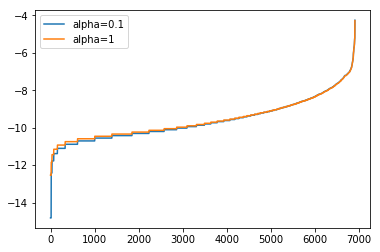

In [85]:
plt.plot(np.log(np.sort(pi_posterior)), label="alpha=0.1")
plt.plot(np.log(np.sort(pi_posterior_uniform)), label="alpha=1")
plt.legend()

## Question 6:

Implement the Latent Dirichlet allocation topic model as described in the previous lectures.
Set the hyperparameters α = 0.1, γ = 0.1 and set number of topics K = 20. Plot the topic
posteriors of the document 1 as a function of the number of Gibbs sweeps, up to 20 sweeps.
Comment on these.

[1.79337456e-05 6.45614841e-05 5.02144876e-05 ... 6.45614841e-05
 1.18362721e-04 2.51072438e-05]
Uniform prior perplexity = 2683.984070350858


In [26]:
log_p_word = np.zeros_like(p_word)

non_zero_idx = p_word > 0

log_p_word[non_zero_idx] = np.log(p_word[non_zero_idx])

In [43]:
for word in test[:,1:3]:
    p = p_word[word[0]-1]
    p**word[1]

2.519922202485122e-12
0.00035307357906273675
0.00039720777644557885
0.00013240259214852628
0.002982736173123745
0.00011401334323900874
0.00012136904280281576
0.0001360804419304298
9.56240943294912e-05
2.9422798255228063e-05
0.00025377163495134207
1.1292015506332803e-11
0.0001912481886589824
1.1375852954346299e-08
1.706381291241184e-14
9.930194411139471e-05
0.0002721608838608596
9.19462445475877e-05
3.669135862640713e-14
9.551061699918559e-15
2.2067098691421047e-05
0.0001360804419304298
3.949400936171055e-08
5.402840297784563e-06
1.0474982791731003e-07
2.2067098691421047e-05
0.0001360804419304298
0.0005847781153226578
0.0005994895144502718
1.7530446407648994e-08
9.56240943294912e-05
4.161693331208124e-10
1.1991013126104571e-17
0.0006142009135778858
0.0003162950812437017
7.355699563807016e-05
0.0003641071284084473
0.0001912481886589824
9.56240943294912e-05
6.620129607426314e-05
0.0010739321363158244
2.371269685582203e-19
8.826839476568419e-05
1.8665690546511086e-22
0.0001434361414942368


0.0010739321363158244
0.0011070327843529558
0.00011401334323900874
0.0001360804419304298
9.56240943294912e-05
0.0004266305747008069
8.417806768589251e-26
6.987914585616665e-05
1.838924890951754e-05
6.620129607426314e-05
3.677849781903508e-05
1.463034786613669e-07
0.00022802668647801749
9.356199441131739e-07
0.0016256096036013504
0.00019860388822278942
0.00022802668647801749
0.0008091269520187717
8.459054498378068e-05
6.0902204637548545e-06
0.0010040529904596577
0.0002868722829884736
8.091269520187717e-05
0.00010297979389329822
0.0015373412088356662
0.0009599187930768155
0.00011401334323900874
0.0008348719004920963
2.5744948473324555e-05
3.183918444298419e-12
0.0003677849781903508
4.415217717685377e-08
7.355699563807016e-05
0.0005296103685941051
0.00015814754062185084
0.0005553553170674297
0.00012872474236662277
5.677156052181337e-08
1.5847463036572798e-09
6.628023718941363e-08
0.0002942279825522806
0.0004670869223017455
0.00019860388822278942
9.19462445475877e-05
0.00015814754062185084

9.19462445475877e-05
0.00012504689258471927
1.4711399127614031e-05
0.0002758387336427631
2.2067098691421047e-05
1.947827378627666e-09
1.5605205726763885e-10
0.0003677849781903508
0.0008238383511463858
2.9422798255228063e-05
0.00048179832142935955
2.2067098691421047e-05
0.0005553553170674297
2.1819314870022938e-10
0.003258574906766508
8.826839476568419e-05
0.002865044980102833
0.0002795165834246666
0.0001912481886589824
0.00028319443320657013
0.0004119191755731929
0.0008973953467844559
2.5744948473324555e-05
4.0456347600938586e-05
0.0006215566131416928
0.00011401334323900874
8.826839476568419e-05
4.78120471647456e-05
0.00012872474236662277
0.00038985207688177183
0.0006914357589978595
0.0002721608838608596
1.6744653496229577e-22
0.00044869767339222796
0.0027914879844647624
2.5744948473324555e-05
0.0003824963773179648
4.0456347600938586e-05
3.873873571177886e-11
0.0002611273345151491
0.00013240259214852628
0.0006178787633597893
1.1033549345710523e-05
4.4134197382842094e-05
0.0002831944332

6.252344629235963e-05
4.2377419406268156e-07
1.2207737563968534e-07
0.0010150865398053683
9.290631951208241e-14
0.005700667161950437
9.512260537206673e-14
0.003258574906766508
0.0005112211196845876
0.0004670869223017455
6.620129607426314e-05
0.00011033549345710523
4.4134197382842094e-05
2.5744948473324555e-05
0.0008753282480930349
0.00011033549345710523
0.00037881852753606133
0.0001360804419304298
0.0006987914585616665
0.00013240259214852628
4.4134197382842094e-05
0.0004192748751369999
8.091269520187717e-05
0.00035307357906273675
0.00011401334323900874
0.0007576370550721227
6.266906673912578e-11
0.0002684830340789561
0.0005443217677217192
5.148989694664911e-05
0.003427755996734069
1.4073052810584886e-07
2.9422798255228063e-05
0.00020595958778659644
0.0003383621799351227
0.00015446969083994733
7.723484541997366e-05
3.677849781903508e-05
0.0001434361414942368
0.0005847781153226578
0.0007649927546359296
0.0005847781153226578
0.000463409072519842
0.0007944155528911577
0.0005479996175036226

6.987914585616665e-05
0.002622306894497201
9.56240943294912e-05
0.00012504689258471927
0.00012504689258471927
0.00044869767339222796
0.000478120471647456
0.00029790583233418416
8.826839476568419e-05
4.4134197382842094e-05
2.2067098691421047e-05
7.355699563807016e-05
0.003431433846515973
0.00011033549345710523
2.2067098691421047e-05
0.00017285893974946487
9.145137232745724e-08
0.00016550324018565785
0.00013240259214852628
4.4134197382842094e-05
3.6958930172765127e-13
1.1875917054071897e-05
0.0008091269520187717
0.0010776099860977278
0.0004450198236103245
0.0017102001485851312
0.0019235154359355346
0.00038617422709986835
6.252344629235963e-05
7.723484541997366e-05
2.9422798255228063e-05
0.0007944155528911577
0.0004928318707750701
9.19462445475877e-05
0.0008311940507101928
0.0004891540209931665
9.19462445475877e-05
0.0003162950812437017
0.0003052615318979912
0.00022434883669611398
0.0006325901624874033
0.0005443217677217192
0.00016918108996756136
4.4134197382842094e-05
0.00011769119302091

KeyboardInterrupt: 

In [15]:
for document_id, word_id, count in train.iterrows():
    counts[word_id] += count

ValueError: not enough values to unpack (expected 3, got 2)

In [287]:
total = sum(train.num)
grouped_train = train.drop("document_id", axis=1).groupby("word_id").sum()

word_ids = np.array(grouped_train.index)
word_probs = grouped_train.num.values / total

In [290]:
dictionary[word_ids[np.argsort(word_probs)[-20:]]]

array([['timed'],
       ['statebystate'],
       ['republicans'],
       ['voted'],
       ['elections'],
       ['peoples'],
       ['presidential'],
       ['demographic'],
       ['campaigned'],
       ['republicansforkerry'],
       ['senategovernors'],
       ['iraqi'],
       ['ward'],
       ['generally'],
       ['democraticleaning'],
       ['household'],
       ['polled'],
       ['npr'],
       ['kerryedwards'],
       ['bushcheney']], dtype=object)

In [32]:
words = train.loc[train.document_id == 1].word_id.values

In [42]:
doc = train.loc[train.document_id == 1]

In [162]:
word_ids = doc.word_id

total = sum(doc.num.values)

def unigram_prob(p):
    return -scipy.stats.multinomial.pmf(doc.num.values, n=total, p=p)

In [152]:
len(doc.num.values)

183

In [170]:
scipy.optimize.minimize(unigram_prob, doc.num.values / total, options={"maxiter": 10000})

      fun: -3.735112555180694e-88
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([4.90141552e-91, 4.90141552e-91, 4.90141552e-91, 3.70455432e-91,
       4.90141552e-91, 4.90141552e-91, 4.90141552e-91, 4.90141552e-91,
       4.90141552e-91, 4.90141552e-91, 4.90141552e-91, 4.90141552e-91,
       4.90141552e-91, 4.90141552e-91, 4.90141552e-91, 4.90141552e-91,
       4.90141552e-91, 4.90141552e-91, 4.90141552e-91, 4.90141552e-91,
       2.73567203e-91, 4.90141552e-91, 4.90141552e-91, 3.07765913e-91,
       4.90141552e-91, 4.90141552e-91, 4.90141552e-91, 3.70455432e-91,
       4.90141552e-91, 4.90141552e-91, 4.90141552e-91, 4.90141552e-91,
       4.90141552e-91, 4.90141552e-91, 4.90141552e-91, 4.90141552e-91,
       3.30560059e-91, 4.90141552e-91, 3.70455432e-91, 4.90141552e-91,
       4.90141552e-91, 4.9014

In [155]:
p = scipy.stats.dirichlet.rvs(alpha=np.repeat(0.1, len(words)), size=1)[0]
unigram_prob(p)

-0.0

In [157]:
ps = scipy.stats.dirichlet.rvs(alpha=np.repeat(0.1, len(words)), size=10000)

In [161]:
min(unigram_prob(ps))

-0.0

In [88]:
scipy.stats.multinomial.pmf([2,10], n=5, p=[0.3, 0.7])

0.0

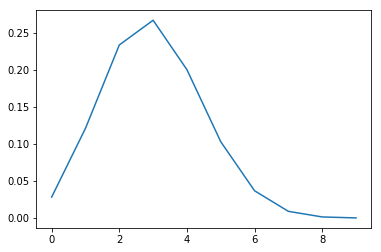

In [83]:
plt.plot(scipy.stats.binom.pmf(range(10), n=10, p=0.3))

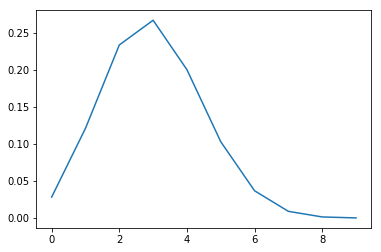

In [71]:
plt.plot(scipy.stats.binom.pmf(range(10), p=0.3, n=10))

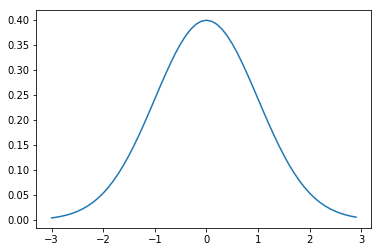

In [79]:
x = np.arange(-3, 3, 0.1)
plt.plot(x, scipy.stats.norm.pdf(x, loc=0, scale=1))

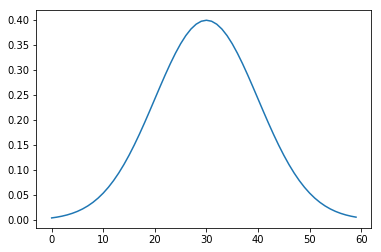

In [80]:
plt.plot(scipy.stats.norm.pdf(np.arange(-3, 3, 0.1), loc=0, scale=1))